<a href="https://colab.research.google.com/github/yashkarbhari/RCNN/blob/master/airplane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
import tensorflow as tf
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
path = "/content/drive/My Drive/Images"
annot = "/content/drive/My Drive/Airplanes_Annotations"

airplane_120.jpg


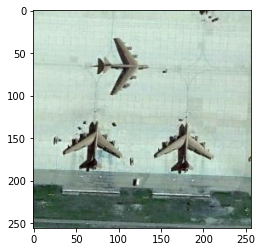

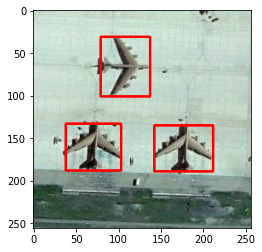

In [4]:
Index=120
filename = "airplane_"+str(Index)+".jpg"
print(filename)
img = cv2.imread(os.path.join(path,filename))
df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
plt.imshow(img)
for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)

In [5]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

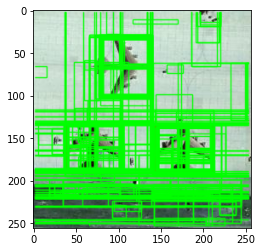

In [6]:
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [7]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [8]:
train_images=[]
train_labels=[]

In [9]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image 
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()   
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 30:       # getting only 30 psoitive examples
                            if iou > 0.70:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <30:      # 30 negatve examples are allowed only
                            if iou < 0.3:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:  
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

1 airplane_023.jpg
2 airplane_154.jpg
3 airplane_227.jpg
4 airplane_256.jpg
5 airplane_021.jpg
6 airplane_209.jpg
7 airplane_261.jpg
8 airplane_136.jpg
inside
9 airplane_263.jpg
10 airplane_096.jpg
inside
11 airplane_258.jpg
12 airplane_041.jpg
inside
13 airplane_025.jpg
14 airplane_108.jpg
inside
15 airplane_153.jpg
16 airplane_171.jpg
17 airplane_203.jpg
18 airplane_254.jpg
19 airplane_109.jpg
20 airplane_186.jpg
22 airplane_174.jpg
23 airplane_077.jpg
24 airplane_159.jpg
25 airplane_071.jpg
26 airplane_083.jpg
inside
27 airplane_266.jpg
28 airplane_229.jpg
30 airplane_262.jpg
31 airplane_294.jpg
32 airplane_095.jpg
33 airplane_125.jpg
34 airplane_297.jpg
inside
35 airplane_284.jpg
36 airplane_316.jpg
37 airplane_244.jpg
38 airplane_221.jpg
39 airplane_120.jpg
inside
40 airplane_189.jpg
41 airplane_022.jpg
42 airplane_089.jpg
43 airplane_152.jpg
44 airplane_074.jpg
45 airplane_269.jpg
46 airplane_042.jpg
47 airplane_259.jpg
48 airplane_286.jpg
49 airplane_127.jpg
50 airplane_103.jpg


In [10]:
X_new = np.array(train_images)
Y_new = np.array(train_labels)

In [11]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

In [12]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
    layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

553467904/553467096 [==============================] - 5s 0us/step


In [18]:
model.summary()
vgg_model = model.fit(X_new,Y_new,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

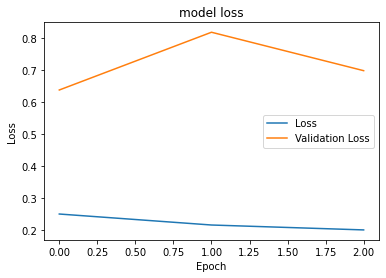

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(vgg_model.history['loss'])
plt.plot(vgg_model.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

0 [[-1.5931318  0.9027792]]
1 [[-1.0363668   0.79253584]]
2 [[-0.65981877 -0.61323714]]
3 [[-0.41945124  0.5556673 ]]
4 [[-0.9478056 -0.5940639]]
5 [[-0.7408905   0.07840282]]
6 [[-2.541189   -0.25708956]]
7 [[-0.14067721  0.13614327]]
8 [[ 1.5576984 -1.8629146]]
9 [[-0.86902714 -0.20410344]]
10 [[-0.8318012  2.0297153]]
11 [[0.8016145 1.8877879]]
12 [[-1.169033   0.2562844]]
13 [[ 4.439739  -1.9852978]]
14 [[-0.9986471  -0.22573322]]
15 [[0.37379313 0.10353202]]
16 [[-0.64940774  0.22188726]]
17 [[ 0.40749317 -1.044915  ]]
18 [[-1.4098325 -2.013174 ]]
19 [[ 0.06627953 -0.5089099 ]]
20 [[-0.27538133  1.8699946 ]]
21 [[-0.87788785  0.743555  ]]
22 [[ 0.21683466 -0.19866326]]
23 [[0.05772829 1.3030578 ]]
24 [[-0.8683557   0.07635133]]
25 [[2.0642931 0.2856215]]
26 [[-0.8494436  0.388645 ]]
27 [[-1.871931   0.3516525]]
28 [[1.3100438 1.7223442]]
29 [[-2.459304   -0.69173837]]
30 [[-1.364285   -0.25167692]]
31 [[ 1.1227539  -0.39039662]]
32 [[0.04879761 1.7430959 ]]
33 [[0.3307836  0.38270

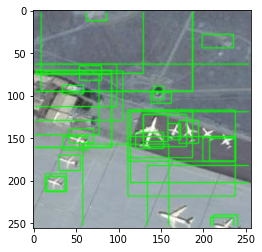

In [20]:
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    print(e,out)
    if(out[0][0]<out[0][1]):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)